# Задание 1
У нас есть данные АА-теста с '2022-03-28' по '2022-04-03'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

4. Пришлите ссылку на merge request c проведенным анализом.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from scipy import stats
from tqdm import tqdm

from read_db.CH import Getch

%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})

Условия:
- **Тест**: АА
- **Метрика**: CTR
- **Даты**: '2022-03-28' по '2022-04-03'
- **Группы**: 2 и 3
- **$\alpha$**: 0.05

## Посмотрим на данные

In [3]:
aa_test_query = """
    SELECT exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes / views as ctr
    FROM simulator_20220420.feed_actions 
    WHERE toDate(time) between '2022-03-28' and '2022-04-03'
        and exp_group in (2, 3)
    GROUP BY exp_group, user_id
"""

In [4]:
aa_test_data = Getch(aa_test_query).df

In [5]:
aa_test_data.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [6]:
# Размеры выборок
aa_test_data.groupby('exp_group').count()[['user_id']]

,user_id
exp_group,
2,8480
3,8569


В группах +- одинаковое количество юзеров

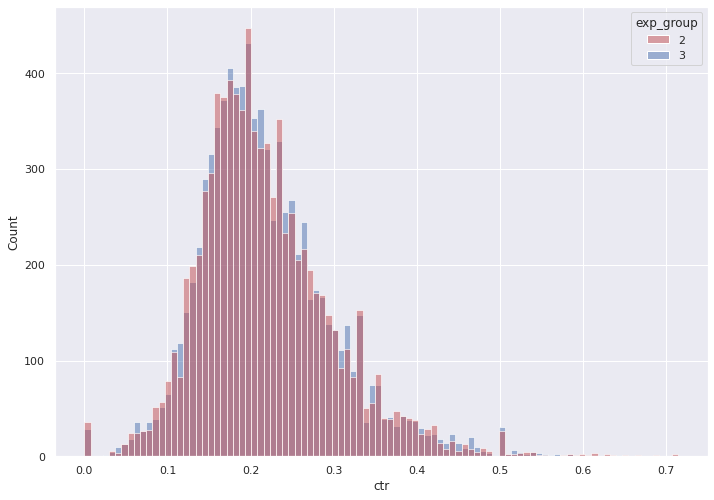

In [7]:
# Посмотрим глазами на группы
groups = sns.histplot(
    data=aa_test_data, 
    x='ctr', 
    hue='exp_group', 
    palette=['r', 'b'],
    alpha=0.5,
    kde=False
)

Распределения выглядят похожими

## Проведем симуляцию

In [8]:
def aa_test_simulation(
    group1: pd.Series, 
    group2: pd.Series, 
    sample_length: int = 500,
    n_bootstrap: int = 10000
):
    p_values = []
    
    for _ in tqdm(range(n_bootstrap)):
        group_1_sample = group1.sample(sample_length, replace=True)
        group_2_sample = group2.sample(sample_length, replace=True)
        
        _, p_val = stats.ttest_ind(group_1_sample, group_2_sample, equal_var=False)
        p_values.append(p_val)
    
    return p_values  

In [9]:
p_values = aa_test_simulation(
    aa_test_data[aa_test_data['exp_group'] == 2]['ctr'],
    aa_test_data[aa_test_data['exp_group'] == 3]['ctr']
)

100%|██████████| 10000/10000 [00:12<00:00, 818.24it/s]


## Построим гистограмму распределения получившихся 10000 p-values

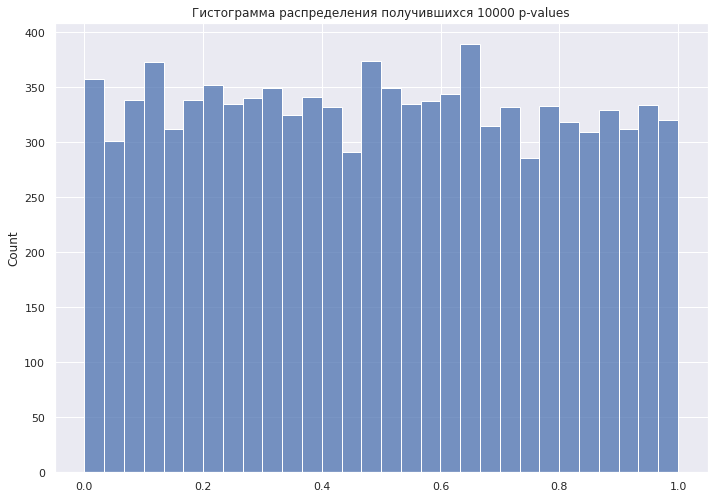

In [10]:
sns.histplot(
    x=p_values, 
    kde=False,
    bins=30
)
plt.title('Гистограмма распределения получившихся 10000 p-values');

Распределение выглядит равномерным, что говорит о том, что у нас мало оснований отвергнуть нулевую гипотезу.

## Посчитаем, какой процент p-values оказался меньше либо равен 0.05

In [11]:
alpha = 0.05

In [12]:
count_false_positive = sum([p < alpha for p in p_values])

In [13]:
count_false_positive / len(p_values) * 100

5.09

Получили значение около 5%, т.е. можно сказать, что ложные срабатывания мы получили случайно.

## Вывод по проведенному АА-тесту

Можно сделать вывод, что наша система сплитования работает корректно, так как:
- Размеры групп примерно одинаковые
- Показатели в этих группах не отличаются друг от друга. Это видно и из сравнения распределений показателя в группах, и в результате проведенной симуляции.
